## Photometry: aperture and PSF photometry code for globular clusters

This notebook contains functions and code to do aperture and PSF photometry on multiple epochs of a globular cluster, tailored to Spitzer observations in channel 1 and 2 (3.6um and 4.5um respectively). In the example at the end of the notebook, Palomar 5 will be used as the current example being studied.
Future revisions: -refine PSF photometry -complete error analysis -align/match stars between epochs -lightcurves

pseudo:
1) list of imports
2) list of functions in order: aperture phot, epsfbuilder, psfphot, FIND, plot, channel? anything else?
3) parameters list - defined
4) code to make functions work

In [1]:
import math
import glob
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from astropy.io import fits # used for FITS file management
from astropy.stats import sigma_clipped_stats # used within star detection
from astropy.table import Table
from astropy.nddata import NDData
from astropy.visualization import simple_norm
from astropy.modeling.fitting import LevMarLSQFitter
from photutils import aperture_photometry # used to perform photometry using annuli
from photutils import DAOStarFinder # used for the star finding algorithm
from photutils import CircularAperture, CircularAnnulus
from photutils import EPSFBuilder
from photutils.psf import extract_stars
from photutils.psf import DAOGroup
from photutils.psf import IterativelySubtractedPSFPhotometry
from photutils.background import MMMBackground

In [18]:
## 1: FUNCTIONS

def Aper_Phot(data, channel, epoch, fwhm, sigma_val, round_val, plot):
    ## APERTURE PHOTOMETRY ##
    # data: input data to be analysed in FITS file data format
    # channel: Spitzer channel of desired image(s) - 1 (or 3.6um) or 2 (or 4.5um) allowed
    # circular_aperture: the aperture to be used in the photometry analysis
    # annuli_aperture: the annuli to be used in the photometry analysis
    
    ## PARAMETERS ##
    channel = channel
    j = epoch
    fwhm = fwhm
    sigma_val = sigma_val
    roundlo = -round_val
    roundhi = round_val
    
    ## CHANNEL ##
    
    # aperture corrections for 337 (6,6,14) apertures in channels 1 & 2, given in IRAC handbook §4.10
    # zmags from IRAC handbook §4.8
    if channel == '3p6um':
        aper_corr = 1.125
        zmag = 18.8
    elif channel == '4p5um':
        aper_corr = 1.120
        zmag = 18.32
    else:
        return print('Input either channel 1 or channel 2 only')
    
    ## SOURCE DETECTION ##
    mean_val, median_val, std_val = sigma_clipped_stats(data, sigma = sigma_val)
    
    daofind = DAOStarFinder(fwhm = fwhm, threshold = sigma_val * std_val, roundlo = roundlo, roundhi = roundhi)
    sources = daofind(data) #- median_val) # necessary here?
    print('Number of stars detected: {}'.format(len(sources)))
    positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
    apertures = CircularAperture(positions, r = 6.)

    if plot == True:
        plt.imshow(data, cmap = 'viridis', origin = 'lower', norm = LogNorm(), interpolation = 'nearest')
        plt.colorbar(fraction = 0.05)
        apertures.plot(color = 'black', lw = 1., alpha = .75)
        plt.title('Aperture photometry on epoch {} in channel {}: sigma = {}, fwhm = {}, roundlo = {}, roundhi = {}'
                  .format(j, channel, sigma_val, fwhm, roundlo, roundhi))
        plt.grid(b = True, which = 'major', lw = .5, alpha = .4, color = 'black')
        plt.gcf().set_size_inches(15, 8)
        plt.savefig(r'aperture_photometry_output_images/aperture_phot_epoch{}_channel{}.png'.format(j, channel))
        plt.show()
        plt.close()
    
    elif plot == False:
        pass
    
    ## APERTURE PHOTOMETRY ##
    
    positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
    circular_apertures = CircularAperture(positions, r = 6.)
    annuli_apertures = CircularAnnulus(positions, r_in = 6., r_out = 14.)    
    apertures = [circular_apertures, annuli_apertures]

    # aperture photometry
    phot_init = aperture_photometry(data, apertures)

    # background subtraction using sigma-clipped median and annuli
    annulus_masks = annuli_apertures.to_mask(method = 'center')

    bkg_median = []
    for mask in annulus_masks:
        annulus_data = mask.multiply(data)
        annulus_data_1d = annulus_data[mask.data > 0] # extract 1D array of data values
        _, median_sigclip, _ = sigma_clipped_stats(annulus_data_1d) # utilise sigma clipping on the annulus masks
        bkg_median.append(median_sigclip)

    bkg_median = np.array(bkg_median)
    # now append bkg_median, aperture background and aperture sum background values to photometry data
    phot_init['annulus_median'] = bkg_median
    phot_init['aper_bkg'] = bkg_median * circular_apertures.area
    phot_init['aper_sum_bkgsub'] = phot_init['aperture_sum_0'] - phot_init['aper_bkg']

    ## APPARENT MAGNITUDE ##

    phot = phot_init                    # redefine photometry table for ease
    phot['bkgsub_flux'] = float('NaN')  # populate new column to convert into flux
    phot['apparent_mag'] = float('NaN') # populate a new table (very quirky here, nans?)

    # convert data back into flux then calculate apparent magnitude
    for i in range(0, len(phot)):
        phot['bkgsub_flux'][i] = phot['aper_sum_bkgsub'][i] * fluxconv / exptime
        for i in range(0, len(phot)):
            if phot['bkgsub_flux'][i] >= 0:
                phot['apparent_mag'][i] = zmag - 2.5 * math.log10(phot['bkgsub_flux'][i] * aper_corr)

    # export into csv file
    phot['id', 'xcenter', 'ycenter', 'apparent_mag'].write(r'C:\Users\lukeb\Documents\MPhys_RRLs\output_files\aperphot_fn_epoch{}_{}.txt'.format(epoch, channel), format = 'csv', overwrite = True)
    return phot

def Find(data, fwhm, sigma_val, round_val):
    
    global star_find, sources
    
    ## PARAMETERS ##
    fwhm = fwhm
    sigma_val = sigma_val
    roundlo = -round_val
    roundhi = round_val

    ## SOURCE DETECTION ##
    
    star_find = DAOStarFinder(fwhm = fwhm, threshold = sigma * std, roundlo = roundlo, roundhi = roundhi)
    sources = star_find(data)
    
def Build_PSF_model(data, channel, j, fwhm, sigma_val, model_threshold, round_val, sharp_val, plot):
    
    ## PARAMETERS ##
    
    fwhm = fwhm
    sigma_val = sigma_val
    model_threshold = model_threshold
    roundlo = -round_val
    roundhi = round_val
    sharphi = sharp_val
    
    ## COUNTER ##
    j = j
    
    ## CHANNEL ##
    
    # aperture corrections for 337 (6,6,14) apertures in channels 1 & 2, given in IRAC handbook §4.10
    # zmags from IRAC handbook §4.8
    if channel == '3p6um':
        aper_corr = 1.125
        zmag = 18.8
    elif channel == '4p5um':
        aper_corr = 1.120
        zmag = 18.32
    else:
        return print('Input either channel 1 or channel 2 only')
    
    mean, median, std = sigma_clipped_stats(data, sigma = sigma_val)

    starfind_init = DAOStarFinder(fwhm = fwhm, threshold = model_threshold * std, roundlo = roundlo, roundhi = roundhi, sharphi = sharphi)
    epsf_sources = starfind_init(data)
    print('Number of model stars = {}'.format(len(epsf_sources)))
    
    if plot == True:

        # plot detected stars for ePSF model to verify good stars
        positions = np.transpose((epsf_sources['xcentroid'], epsf_sources['ycentroid']))
        apertures = CircularAperture(positions, r = 6.)

        plt.imshow(data, cmap = 'viridis', origin = 'lower', norm = LogNorm(), interpolation = 'nearest')
        apertures.plot(color = 'black', lw = 1.)
        plt.colorbar(fraction = 0.05)
        plt.title('Selected ePSF model stars for epoch{}, channel {}: threshold {} * std, fwhm = {}, roundlo = {}, roundhi = {}'
                  .format(j, channel, model_threshold, fwhm, roundlo, roundhi))
        plt.grid(b = True, which = 'major', lw = .5, color = 'black')
        plt.grid(b = True, which = 'minor', lw = .5, color = 'black')
        plt.gcf().set_size_inches(15, 8)
        plt.show()
        plt.close()
    
    elif plot == False:
        pass
    
    ## APERTURE PHOTOMETRY ON MODEL STARS ##
    
    positions = np.transpose((epsf_sources['xcentroid'], epsf_sources['ycentroid']))
    circular_apertures = CircularAperture(positions, r = 6.)
    annuli_apertures = CircularAnnulus(positions, r_in = 6., r_out = 14.)
    apertures = [circular_apertures, annuli_apertures]

    # initial aperture photometry table
    phot_init = aperture_photometry(data, apertures)

    # background subtraction using sigma-clipped median and annuli
    annulus_masks = annuli_apertures.to_mask(method = 'center')

    bkg_median = []
    for mask in annulus_masks:
        annulus_data = mask.multiply(data)
        annulus_data_1d = annulus_data[mask.data > 0] # extract 1D array of data values
        _, median_sigclip, _ = sigma_clipped_stats(annulus_data_1d) # utilise sigma clipping on the annulus masks
        bkg_median.append(median_sigclip)

    bkg_median = np.array(bkg_median)
    # now append bkg_median, aperture background and aperture sum background values to photometry data
    phot_init['annulus_median'] = bkg_median
    phot_init['aper_bkg'] = bkg_median * circular_apertures.area
    phot_init['aper_sum_bkgsub'] = phot_init['aperture_sum_0'] - phot_init['aper_bkg']
    print(phot_init)
    
    ## STAR CUTOUTS FOR ePSF ##

    cutout_size = 200
    hsize = (cutout_size - 1) / 2
    x = epsf_sources['xcentroid']
    y = epsf_sources['ycentroid']
    mask = ((x > hsize) & (x < (data.shape[1] - 1 - hsize)) &
           (y > hsize) & (y < (data.shape[0] - 1 - hsize)))

    # table of star positions
    star_tbl = Table()
    star_tbl['x'] = x[mask]
    star_tbl['y'] = y[mask]
    print('Number of refined model stars = {}'.format(len(star_tbl)))

    if plot == True:
        # visualise stars to verify - not strictly necessary as visual checks should be done before using this script
        cutout_pos = np.transpose((star_tbl['x'], star_tbl['y']))
        cutout_apers = CircularAperture(cutout_pos, r = 6.)

        plt.imshow(data, cmap = 'viridis', origin = 'lower', norm = LogNorm(), interpolation = 'nearest')
        cutout_apers.plot(color = 'black', lw = 1.)
        plt.colorbar(fraction = 0.05)
        plt.title('Selected cutout ePSF model stars with params: threshold {} * std, fwhm = {}, roundlo = {}, roundhi = {}'
                  .format(model_threshold, fwhm, roundlo, roundhi))
        plt.grid(b = True, which = 'major', lw = .5, color = 'black')
        plt.grid(b = True, which = 'minor', lw = .5, color = 'black')
        plt.gcf().set_size_inches(15, 8)
        plt.show()
        plt.close()
        
    elif plot == False:
        pass
    
    ## EXTRACT STARS ##

    mean_val, median_val, std_val = sigma_clipped_stats(data, sigma = sigma_val)
    sub_data = data - median_val

    nddata = NDData(data = sub_data)
    stars = extract_stars(nddata, star_tbl, size = 25)
    
    if plot == True:
        # visualise 36 extracted stars
        nrows = 3
        ncols = 3
        fig, ax = plt.subplots(nrows = nrows, ncols = ncols, figsize = (20,20), squeeze = True)
        ax = ax.ravel()
        for i in range(nrows * ncols):
            norm = simple_norm(stars[i], 'log', percent = 99.)
            ax[i].imshow(stars[i], cmap = 'viridis', norm = norm, origin = 'lower')
        plt.show()
        plt.close()
    
    elif plot == False:
        pass

    ## BUILD ePSF ##
    global epsf, fitter

    epsf_builder = EPSFBuilder(oversampling = 2, maxiters = 10, progress_bar = True)
    epsf, fitter = epsf_builder(stars)

    norm = simple_norm(epsf.data, 'log', percent = 99.)
    plt.imshow(epsf.data, cmap = 'viridis', norm = norm, origin = 'lower')
    plt.colorbar()
    plt.show()
    plt.close()
    
    return epsf, fitter
    
def PSF_phot(data, channel, epoch, fwhm, sigma_val, round_val, sharp_val, niters, plot):
    
    ## PARAMETERS ##
    channel = channel
    fwhm = fwhm
    sigma_val = sigma_val
    roundlo = -round_val
    roundhi = round_val
    sharohi = sharp_val
    ## COUNTER ##
    j = epoch

    ## CHANNEL ##
    
    # aperture corrections for 337 (6,6,14) apertures in channels 1 & 2, given in IRAC handbook §4.10
    # zmags from IRAC handbook §4.8
    if channel == '3p6um':
        aper_corr = 1.125
        zmag = 18.8
    elif channel == '4p5um':
        aper_corr = 1.120
        zmag = 18.32
    else:
        return print('Input either channel 1 or channel 2 only')
    
    ## SOURCE DETECTION ON ORIGINAL IMAGE ##

    mean_val, median_val, std_val = sigma_clipped_stats(data, sigma = sigma_val)
    
    psf_daofind = DAOStarFinder(fwhm = fwhm, threshold = sigma_val * std_val, roundlo = roundlo, roundhi = roundhi)
    psf_sources = psf_daofind(data)

    psf_positions = np.transpose((psf_sources['xcentroid'], psf_sources['ycentroid']))
    psf_apertures = CircularAperture(psf_positions, r = 6.)

    if plot == True:
        plt.imshow(data, cmap = 'viridis', origin = 'lower', norm = LogNorm(), interpolation = 'nearest')
        psf_apertures.plot(color = 'black', lw = 1.)
        plt.colorbar(fraction = 0.05)
        plt.title('Detected PSF stars for epoch{} in channel {}: threshold {} * std, fwhm = {}, roundlo = {}, roundhi = {}'
                  .format(j, channel, sigma_val, fwhm, roundlo, roundhi))
        plt.grid(b = True, which = 'major', lw = .5, color = 'black')
        plt.grid(b = True, which = 'minor', lw = .5, color = 'black')
        plt.gcf().set_size_inches(15, 8)
        plt.show()
    
    elif plot == False:
        pass
    
    print('Number of stars detected = {}'.format(len(psf_sources)))

    ## GROUP ##

    psf_sources['xcentroid'].name = 'x_0'
    psf_sources['ycentroid'].name = 'y_0'

    daogroup = DAOGroup(crit_separation = sigma_val * fwhm)
    bkg_estimator = MMMBackground()
    fitter = LevMarLSQFitter()

    data_psf = np.nan_to_num(data, nan = 1**-7)

    ## PHOTOMETRY ##

    PSF_photometry = IterativelySubtractedPSFPhotometry(finder = psf_daofind,
                                                        group_maker = daogroup,
                                                        bkg_estimator = bkg_estimator,
                                                        psf_model = epsf,
                                                        fitter = fitter,
                                                        niters = niters,
                                                        aperture_radius = 6.,
                                                        fitshape = (11, 11))

    result_phot = PSF_photometry(image = data_psf)
    residual_image = PSF_photometry.get_residual_image()
    print(len(result_phot))
    
    if plot == True:
        # visualise data
        plt.subplot(1, 2, 1)
        plt.imshow(data_psf, cmap = 'viridis', norm = LogNorm(), interpolation = 'nearest', origin = 'lower', vmin = 0.000001, vmax = 10**6)
        plt.title('input data')
        plt.colorbar(orientation = 'horizontal')

        plt.subplot(1, 2, 2)
        plt.imshow(residual_image, cmap = 'viridis', norm = LogNorm(), interpolation = 'nearest', origin = 'lower', vmin = 0.000001, vmax = 10**6)
        plt.title('residual image')
        plt.colorbar(orientation = 'horizontal')
        plt.gcf().set_size_inches(20, 14)
        plt.show()
        plt.close()
        
    elif plot == False:
        pass
    
    ## APPARENT MAGNITUDES ##

    phot = result_phot                  # redefine photometry table for ease
    phot['bkgsub_flux'] = float('NaN')  # populate new column to convert into flux
    phot['apparent_mag'] = float('NaN') # populate a new table (very quirky here, nans?)

    for i in range(0, len(phot)):
        phot['bkgsub_flux'][i] = phot['flux_0'][i] * fluxconv / exptime
        for i in range(0, len(phot)):
            if phot['bkgsub_flux'][i] >= 0:
                phot['apparent_mag'][i] = zmag - 2.5 * math.log10(phot['bkgsub_flux'][i] * aper_corr)

    # export into csv file
    phot['id', 'x_0', 'y_0', 'apparent_mag'].write(r'C:\Users\lukeb\Documents\MPhys_RRLs\output_files\psfphot_epoch{}_{}.txt'.format(j, channel), format = 'csv', overwrite = True)

    # format columns
    for col in phot.colnames:
        phot[col].info.format = '%.8g'
    print(phot['id', 'x_0', 'y_0', 'flux_0', 'apparent_mag'])

In [10]:
## BASE DATA DIRECTORY ##

base_dir = 'PAL5_data/*/'
channel = '3p6um'

## PARAMETERS ##

sigma_val = 6.
fwhm = 5.
r_ap = 6.
r_in = 6.
r_out = 14.
round_val = 0.5
sharp_val = 0.7

## LOOP COUNTER ##
j = 0

## FITS FILE SELECTION ##
for file in glob.glob(base_dir+'PAL5__e[0-9]_'+channel+'.fits', recursive = True) + glob.glob(base_dir+'PAL5__e[0-9][0-9]_'+channel+'.fits', recursive = True):
    j += 1
    print('EPOCH NUMBER: {}'.format(j))
    ## OPENING FITS FILE AND EXTRACTING DATA ##
    with fits.open(file) as header_list:
        header = header_list[0].header
        fluxconv = header['FLUXCONV']
        exptime = header['EXPTIME']
        counts = exptime / fluxconv
        image_data = fits.getdata(file, ext = 0)
        data = image_data * counts
        print('FLUXCONV = {}\nEXPTIME = {}'.format(fluxconv, exptime))

    Aper_Phot(data = data,
              channel = channel,
              epoch = j,
              fwhm = fwhm,
              sigma_val = sigma_val,
              round_val = round_val, 
              plot = False)

EPOCH NUMBER: 1
FLUXCONV = 0.1257
EXPTIME = 71.3724


Number of stars detected: 597


EPOCH NUMBER: 2
FLUXCONV = 0.1257
EXPTIME = 71.3424


Number of stars detected: 584


EPOCH NUMBER: 3
FLUXCONV = 0.1257
EXPTIME = 71.3767


Number of stars detected: 604


EPOCH NUMBER: 4
FLUXCONV = 0.1257
EXPTIME = 71.3582


Number of stars detected: 592


EPOCH NUMBER: 5
FLUXCONV = 0.1257
EXPTIME = 71.3583


Number of stars detected: 581


EPOCH NUMBER: 6
FLUXCONV = 0.1257
EXPTIME = 71.3658


Number of stars detected: 566


EPOCH NUMBER: 7
FLUXCONV = 0.1257
EXPTIME = 71.3767


Number of stars detected: 597


EPOCH NUMBER: 8
FLUXCONV = 0.1257
EXPTIME = 71.3917


Number of stars detected: 584


EPOCH NUMBER: 9
FLUXCONV = 0.1257
EXPTIME = 71.3482


Number of stars detected: 558


EPOCH NUMBER: 10
FLUXCONV = 0.1257
EXPTIME = 71.3432


Number of stars detected: 577


EPOCH NUMBER: 11
FLUXCONV = 0.1257
EXPTIME = 71.3545


Number of stars detected: 572


EPOCH NUMBER: 12
FLUXCONV = 0.1257
EXPTIME = 71.336


Number of stars detected: 573


EPOCH NUMBER: 1
FLUXCONV = 0.1257
EXPTIME = 71.3724


Number of model stars = 46
 id      xcenter       ...      aper_bkg       aper_sum_bkgsub  
           pix         ...                                      
--- ------------------ ... ------------------ ------------------
  1 1325.4233008232586 ... 10121.479821030493                nan
  2 386.74295292483225 ...  5529.953810103007 38796.442407212395
  3  609.1207788533914 ...   4242.52160498129 10810.107057863164
  4 63.841924403069605 ...  4474.694199170145 122977.99359934543
  5 1142.6191445428262 ...  6213.305147945754  33401.67795837177
  6 1257.6453165205398 ...  6496.728208037017  73457.07486642095
  7 142.19432814143948 ...  9266.086737461517  288163.1906789933
  8 334.22885916889885 ...  4862.194428231126 19112.558213523636
  9 1388.3105215450903 ...  6257.736613845463  75313.84508638266
 10 1162.1295541826387 ...  6506.260053063091 100461.73778318102
...                ... ...                ...                ...
 37  466.7058234166519 ...  7303.325674333197 113253.5021389407

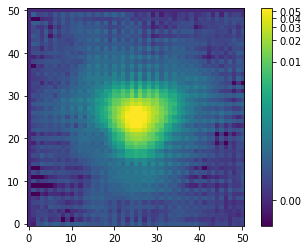

Number of stars detected = 597


704
 id    x_0       y_0      flux_0   apparent_mag
--- --------- --------- ---------- ------------
  1 1093.0175 18.891553  1092.6398    17.961414
  2   1116.16 19.372724 -1500.9192          nan
  6 1138.3723 28.990912  2922.1701    16.893343
 12 1150.0528 41.601753    14978.9    15.118906
 18 1127.7088 47.665985  4438.7694     16.43945
 21 1132.5348 49.839855  5797.1409    16.149572
 35  1101.289 71.444989  2330.1038    17.139168
 44  1124.128 78.169821  2598.0048    17.021006
 63 1094.9217 94.902401  1941.4225    17.337306
 66 1077.0733 98.524446  2571.5496    17.032119
...       ...       ...        ...          ...
 62 757.07648 623.97925 -2153.3298          nan
 65 762.49807 634.01689  -1574.609          nan
 61 83.984006 621.89501 -2137.9485          nan
 63 84.121817 632.12075 -3223.9016          nan
 66 89.838592 638.30967 -68.247848          nan
 67 84.116192  642.9448 -2143.6771          nan
 70 90.462887 657.29032 -1281.6745          nan
 71  84.04374 677.09016 -2633.6003  

Number of model stars = 47
 id      xcenter       ...      aper_bkg       aper_sum_bkgsub  
           pix         ...                                      
--- ------------------ ... ------------------ ------------------
  1 387.20865058168016 ...  4464.925282206993  37819.95977923774
  2  1288.019934867026 ...  7621.010267227235  33253.04792246037
  3  901.7533111560487 ...   5926.71257195687 27501.142832834536
  4 1142.8097026322089 ...  5391.401333726652  32979.64467343563
  5 1257.6873364244952 ...   5775.15004499171  75953.57315842151
  6 142.21993764730817 ...    8362.0876510262  292319.4313537541
  7 334.27143122646214 ...  3949.868702331567  17674.76728038909
  8 1388.5304822901012 ...  5466.707590470884                nan
  9 1162.2091218096361 ...  5776.676451749456 100043.20367216454
 10 1122.1144881725825 ...  5462.975918551404  30706.18213761795
...                ... ...                ...                ...
 38  929.1400095082789 ...  7691.107197121157 151940.5212844957

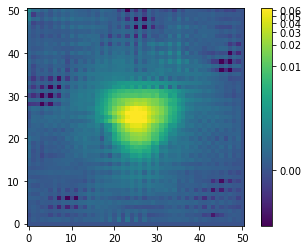

Number of stars detected = 584


KeyboardInterrupt: 

In [19]:
## BASE DATA DIRECTORY ##

base_dir = 'PAL5_data/*/'
channel = '3p6um'

## PARAMETERS ##

sigma_val = 6.
fwhm = 5.
model_threshold = 100.
r_ap = 6.
r_in = 6.
r_out = 14.
round_val = 0.5
sharp_val = 0.8

## LOOP COUNTER ##
j = 0

## FITS FILE SELECTION ##
for file in glob.glob(base_dir+'PAL5__e[0-9]_'+channel+'.fits', recursive = True) + glob.glob(base_dir+'PAL5__e[0-9][0-9]_'+channel+'.fits', recursive = True):
    j += 1
    print('EPOCH NUMBER: {}'.format(j))
    ## OPENING FITS FILE AND EXTRACTING DATA ##
    with fits.open(file) as header_list:
        header = header_list[0].header
        fluxconv = header['FLUXCONV']
        exptime = header['EXPTIME']
        counts = exptime / fluxconv
        image_data = fits.getdata(file, ext = 0)
        data = image_data * counts
        print('FLUXCONV = {}\nEXPTIME = {}'.format(fluxconv, exptime))

    Build_PSF_model(data = data,
                    channel = channel,
                    j = j,
                    fwhm = fwhm, 
                    sigma_val = sigma_val, 
                    model_threshold = model_threshold, 
                    round_val = round_val, 
                    sharp_val = sharp_val, 
                    plot = False)
    
    PSF_phot(data = data,
                    channel = channel,
                    epoch = j,
                    fwhm = fwhm, 
                    sigma_val = sigma_val, 
                    round_val = round_val, 
                    sharp_val = sharp_val,
                    niters = 2,
                    plot = False)